# Robust PCA Implementation
In this assignment question, we want to assess your ability to implement an optimization algorithm from a given paper. 

The task is to implement:
Algorithm 1 (Principal Component Pursuit by Alternating Directions) described on page 29 in

https://statweb.stanford.edu/~candes/papers/RobustPCA.pdf

Although the paper is filled with complex proofs, the concept is straight forward and the algorithm can be implemented with a reasonable amount of code.

## Background
Electricity prices tend to vary smoothly in response to supply and demand signals, but are subject to intermittent price spikes that deviate substantially from normal behaviour.

Forming the price data from one commerical trading hub into a matrix $M$ with each day as a row and each hour as a column, we can consider $M$ as the combination of a low-rank matrix $L$ consisting of the normal daily market behaviour, and a sparse matrix $S$ consisting of the intermittent price spikes.

$M$ = $L + S$

Since we can only measure the market prices $M$, we wish estimate $L$ and $S$ by solving the Robust PCA problem:

$\min{\|L\|_* + \lambda |S|_1}$

subject to $L + S = M$ 

## Dataset

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

(244, 24)


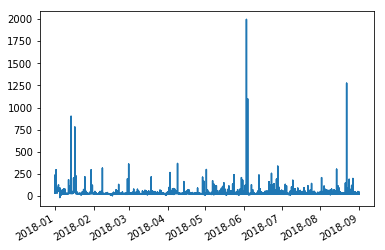

In [2]:
data = pd.read_csv("Question1.csv", index_col=0, parse_dates=True)

# Unroll the daily values to plot the timeseries. Note the spikes we wish to separate.
timeseries = data.stack()
timeseries.index = timeseries.index.droplevel(1)
timeseries.plot()

M = data.values
print(M.shape)

The matrix $M$ is 244 rows (days) by 24 columns (hours).

## Implementation

Solve for $L$ and $S$, the low-rank component and sparse component of the matrix $M$.

## Calculate parameters
$\mu$, $\lambda$

In [3]:
# Calculate $\mu$
mu = np.prod(M.shape)/(4*np.linalg.norm(M,1))
print(mu)
mu_inv = 1/mu
print(mu_inv)

0.11778780976625072
8.489842896174864


In [4]:
# Calculate $\lambda$
lmbda = 1/np.sqrt(np.max(M.shape[0]))
print(lmbda)

0.06401843996644799


## Operators
We write two functions to calculate the shrinkage and singular value thresholding operators.

In [5]:
# Method for getting S_tau_x, shrinkage operator
def S_tau_X (X, tau):
    return np.sign(X)*np.maximum((np.abs(X) - tau), np.zeros(X.shape))

# Method for getting D_tau(X), singular value thresholding operator
def D_tau_X (X, tau):
    # First take the SVD of X
    U,S,V = np.linalg.svd(X, full_matrices=False)
    
    # Then apply shrinkage to S
    return np.matmul(U, np.matmul(np.diag(S_tau_X(S, tau)), V))

## Optimization

In [6]:
# Optimization paremeters
delta = 1e-7
tol = delta * np.linalg.norm(M, 'fro')
max_itr = 1000
error = np.Inf
itr_count = 0

# Initialize  S, Y
Sk = np.zeros(M.shape)
Yk = np.zeros(M.shape)

# Defining Lk 
Lk = np.zeros(M.shape)

# Optimization loop
while tol < error and itr_count < max_itr:
    # First compute L_{k+1}
    Lk = D_tau_X(M - Sk + mu_inv*Yk, mu_inv)
    
    # Next S_{k+1}
    Sk = S_tau_X(M - Lk + mu_inv*Yk, lmbda*mu_inv)
    
    # Then Y_{k+1}
    Yk = Yk + mu*(M - Lk - Sk)
    
    # Calculate error
    error = np.linalg.norm(M - Lk - Sk, 'fro')
    
    # Increment the counter
    itr_count = itr_count + 1
    
    # Print iteration results (every 20 iteration)
    if itr_count == 1 or (itr_count % 100) == 0 or tol >= error or itr_count > max_itr:
        print('####################')
        print('iteration no:')
        print(itr_count) 
        print('error:')
        print(error) 
        print('####################')

####################
iteration no:
1
error:
18.68011118685079
####################
####################
iteration no:
100
error:
0.6217021782947165
####################
####################
iteration no:
200
error:
0.6028551247601494
####################
####################
iteration no:
300
error:
0.3410113276793077
####################
####################
iteration no:
400
error:
0.15908784615708543
####################
####################
iteration no:
500
error:
0.02503334877534937
####################
####################
iteration no:
600
error:
0.007308872647851959
####################
####################
iteration no:
700
error:
0.0021313879580739255
####################
####################
iteration no:
800
error:
0.0006126047208872991
####################
####################
iteration no:
819
error:
0.00047647293765837713
####################


## Results

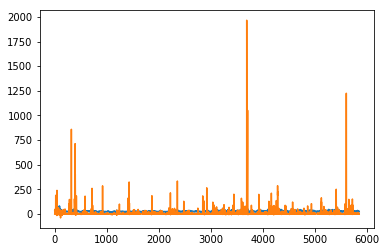

In [7]:
plt.plot(Lk.flatten())
plt.plot(Sk.flatten())

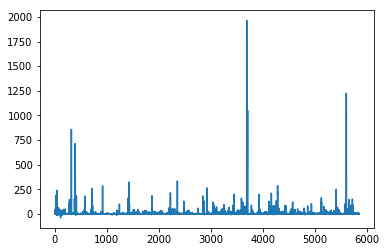

In [8]:
plt.plot(Sk.flatten())

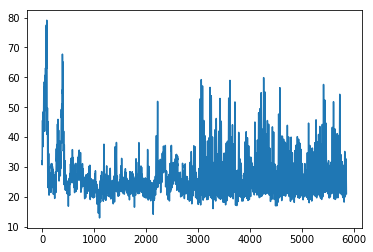

In [9]:
plt.plot(Lk.flatten())